In [39]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# 基于SAM使用提示词来生成目标的Mask

Segment Anything Model (SAM) 在给定指示想要的对象的提示的情况下预测对象掩码。 该模型首先将图像转换为图像嵌入，从而可以根据提示高效地生成高质量的掩码。

`SamPredictor` 类为模型提供了一个简单的接口来提示模型。 它允许用户首先使用 set_image 方法设置图像，该方法计算必要的图像嵌入。 然后，可以通过 `predict` 方法根据这些提示有效地预测掩码。 该模型可以将点和框提示以及来自上一次预测迭代的掩码作为输入。

In [40]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## 环境搭建

如果使用 jupyter 在本地运行，请首先使用仓库中的[安装说明](https://github.com/facebookresearch/segment-anything#installation) 在您的环境中安装“segment_anything”。 如果从 Google Colab 运行，请在下面设置 using_collab=True 并运行该单元格。 在 Colab 中，请务必在'Edit'->'Notebook Settings'->'Hardware accelerator'下选择“GPU”。

In [41]:
import oneflow.mock_torch as mock
mock.enable(lazy=True, extra_dict={"torchvision": "flowvision"})
using_colab = False

In [42]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## 设置

用于显示点、框和掩码的必要导入和辅助函数。

In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [44]:
# 这段代码定义了show_mask()函数,用于在轴ax上显示掩码mask。
# mask是要显示的掩码,ax是matplotlib轴,random_color表示是否使用随机颜色
def show_mask(mask, ax, random_color=False):
    if random_color:
        # 在random_color为True时,生成一个随机RGB颜色加上alpha通道为0.6的颜色array
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        # 否则使用默认的青色加alpha为0.6。
        color = np.array([30/255, 144/255, 255/255, 0.6])
    # 这行获取mask的高h和宽w,mask可以是任意ndim的array。
    h, w = mask.shape[-2:]
    # 这行将 mask reshape为 h×w×1, 将color reshape为 1×1×4, 并相乘得到 mask_image。该操作实现了用颜色 color 为掩码 mask 着色。
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    # 最后, 该行在轴 ax 上显示 mask_image, 完成掩码可视化。
    ax.imshow(mask_image)

# 这段代码定义了 show_points() 函数, 用于在轴 ax 上显示带标签的坐标点。
# coords 是坐标数组, labels 是点的标签, ax 是 matplotlib 轴, marker_size 是点的大小。    
def show_points(coords, labels, ax, marker_size=375):
    # 这行获取 labels 为 1 的坐标点,存储在 pos_points 中。
    pos_points = coords[labels==1]
    # 这行获取 labels 为 0 的坐标点,存储在 neg_points 中。
    neg_points = coords[labels==0]
    # 这行在 ax 上 scatter plot pos_points, 颜色为绿色, 形状为*, 大小为marker_size, 轮廓颜色为白色, 宽度为1.25。
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    # 这行在 ax 上 scatter plot neg_points, 颜色为红色,其它属性与 pos_points 相同。
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

# 这段代码定义了 show_box() 函数,用于在轴 ax 上显示框 box。
# box 表示框的坐标, ax 是 matplotlib 轴。
def show_box(box, ax):
    # 这行获取框左上角坐标 x0 和 y0。
    x0, y0 = box[0], box[1]
    # 这行计算框的宽 w 和高 h。
    w, h = box[2] - box[0], box[3] - box[1]
    # 这行在 ax 上添加 Rectangle patch,表示框。其左上角坐标为 (x0, y0),大小为 (w, h),边框颜色为绿色,填充色为透明,边框宽度为 2。
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## 示例图片

In [45]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

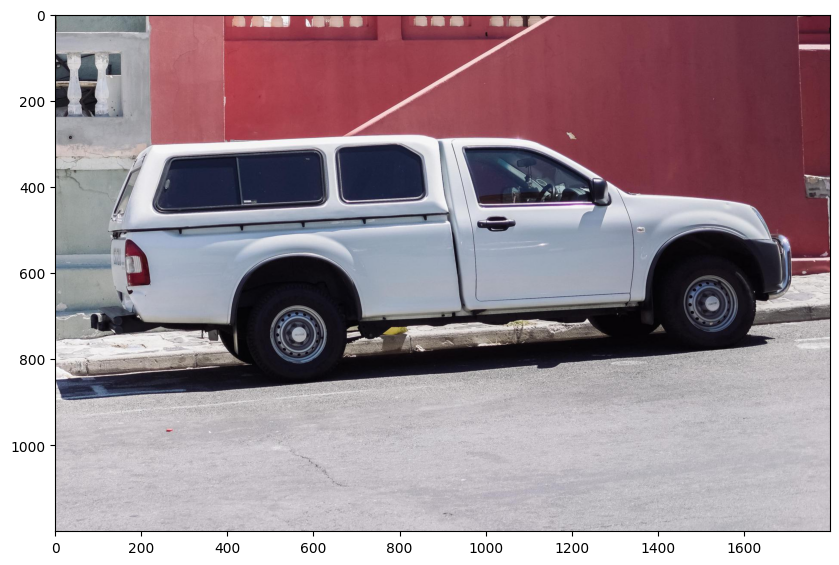

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## 使用 SAM 选择对象

首先，加载 SAM 模型和预测器。 更改下面的路径以指向 SAM checkpoint。 建议在 CUDA 上运行并使用默认模型以获得最佳结果。

In [47]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [48]:
predictor.set_image(image)

要选择卡车，请在其上选择一个点。 点以 (x,y) 格式输入到模型中，并带有标签 1（前景点）或 0（背景点）。 可以输入多个点； 这里我们只使用一个。 所选点将在图像上显示为星号。

In [49]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

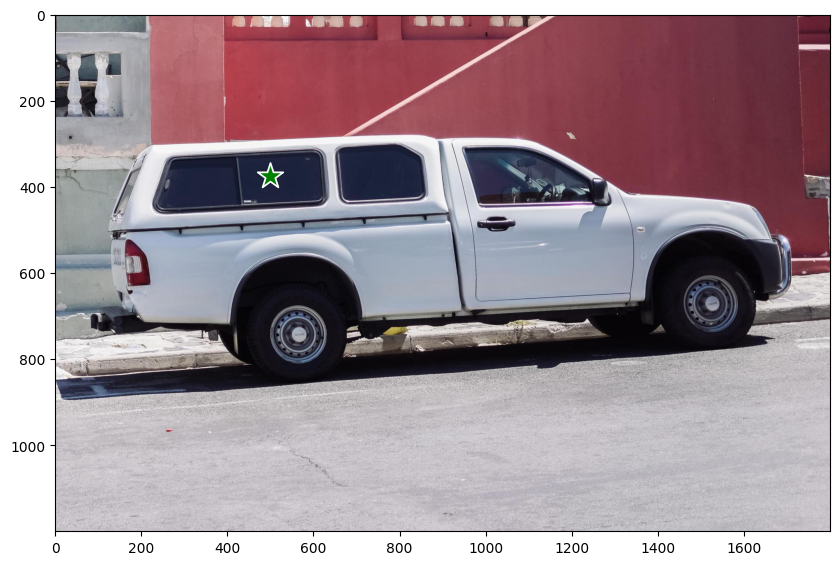

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

使用 `SamPredictor.predict` 进行预测。 该模型返回掩码、这些掩码的质量预测以及可以传递给下一次预测迭代的未归一化的掩码概率。

In [51]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

使用 `multimask_output=True`（默认设置），SAM 输出 3 个掩码，其中 `scores` 给出了模型自己对这些掩码质量的估计。 此设置适用于不明确的输入提示，并帮助模型消除与提示一致的不同对象的歧义。 当为`False`时，它将返回一个掩码。 对于单点等不明确的提示，即使只需要一个掩码，也建议使用 `multimask_output=True`； 可以通过选择“scores”中返回的得分最高的掩码来选择最佳的单个掩码。 这通常会产生更好的掩码。

In [52]:
masks.shape  # (number_of_masks) x H x W

(3, 1200, 1800)

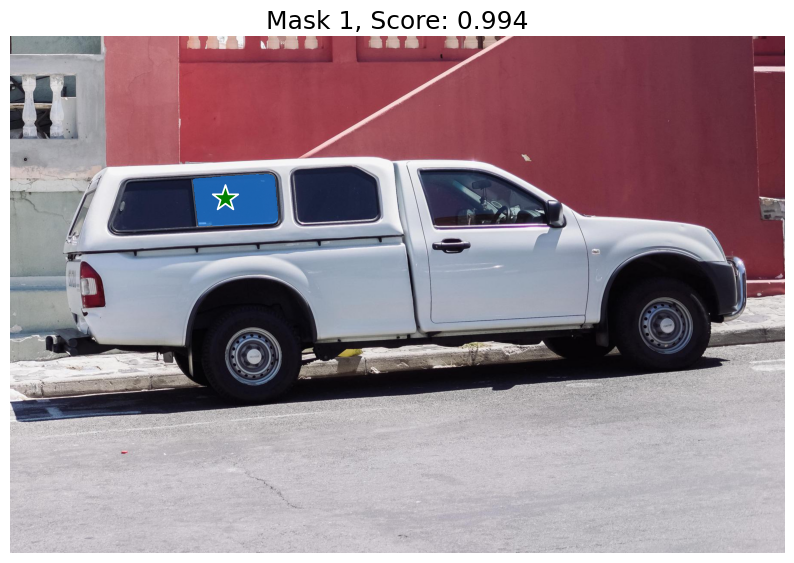

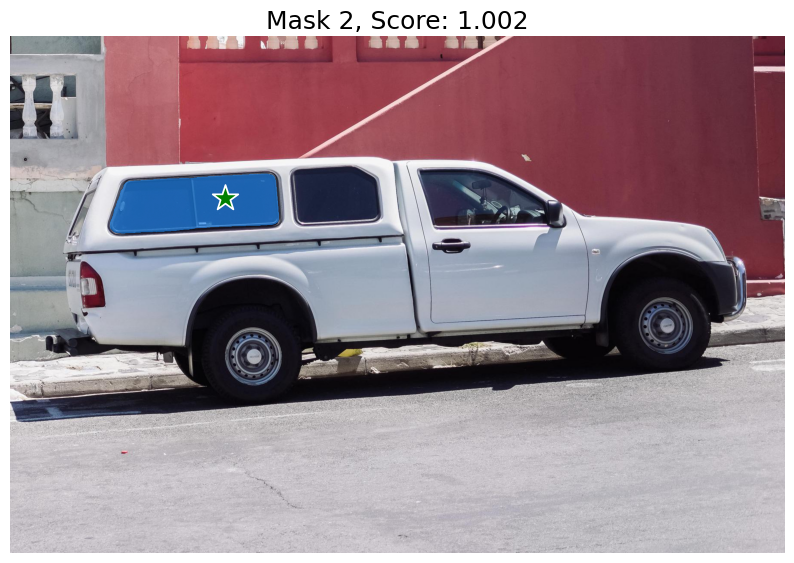

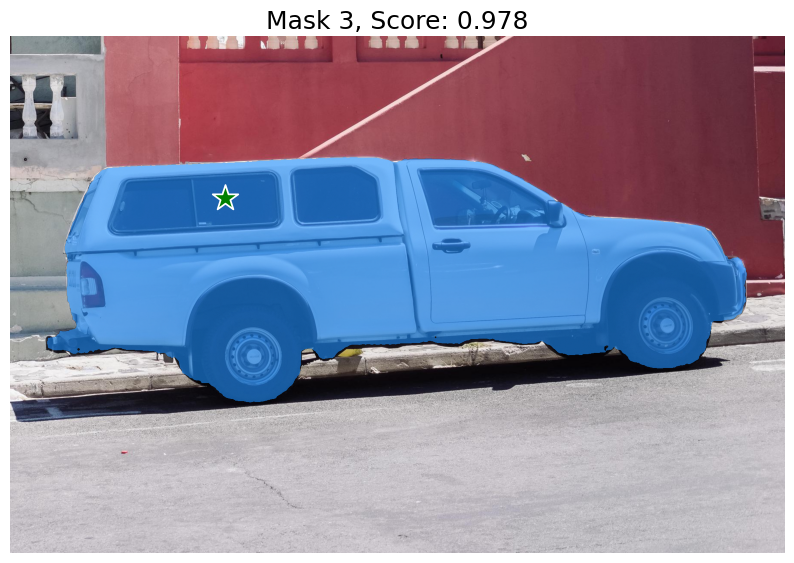

In [53]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## 用附加点指定特定对象

单个输入点不明确，模型返回了与其一致的多个对象。 为了获得单个对象，可以提供多个点。 如果可用，还可以将先前迭代的掩码提供给模型以帮助预测。 当指定具有多个提示的单个对象时，可以通过设置 `multimask_output=False` 请求单个掩码。

In [54]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [55]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [56]:
masks.shape

(1, 1200, 1800)

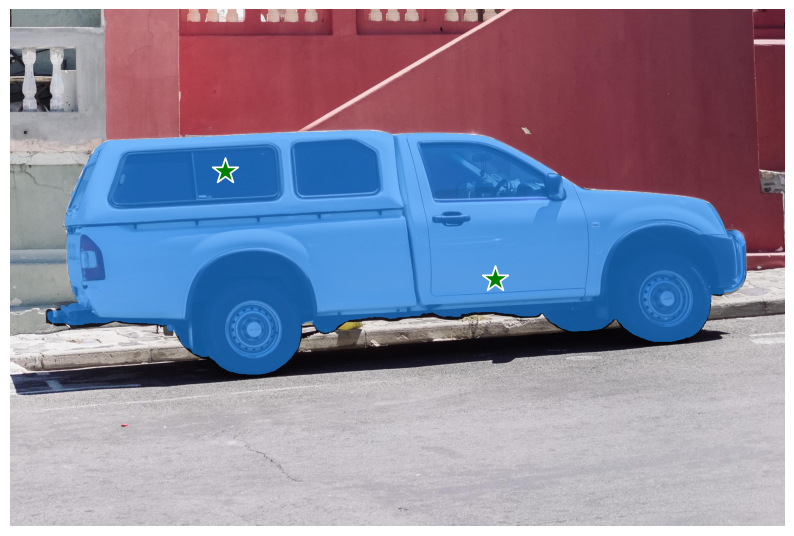

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

要排除汽车并仅指定窗口，可以提供背景点（标签为 0，此处显示为红色）。

In [58]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [59]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

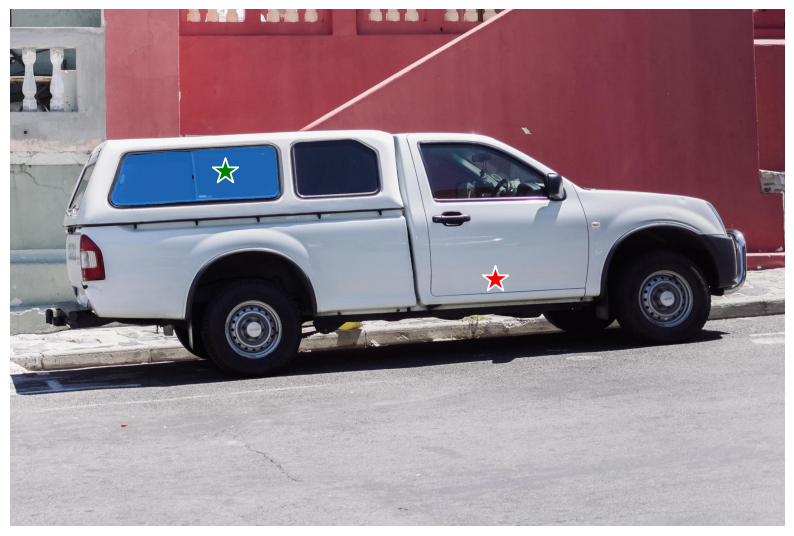

In [60]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## 用框指定特定对象

该模型还可以将一个框作为输入，以 xyxy 格式提供。

In [61]:
input_box = np.array([425, 600, 700, 875])

In [62]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

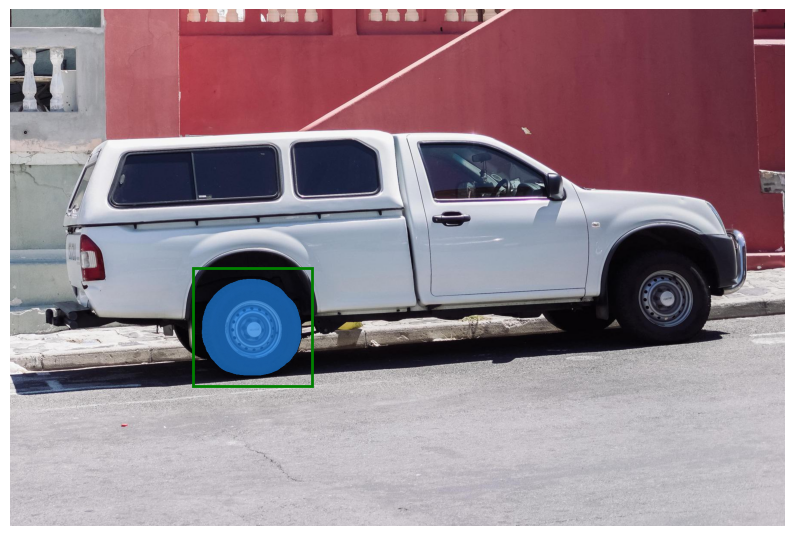

In [63]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## 结合点和框

点和框可以组合，只需将两种类型的提示都包含到预测器中即可。 在这里，这可用于仅选择卡车的轮胎，而不是整个车轮。

In [64]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [65]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

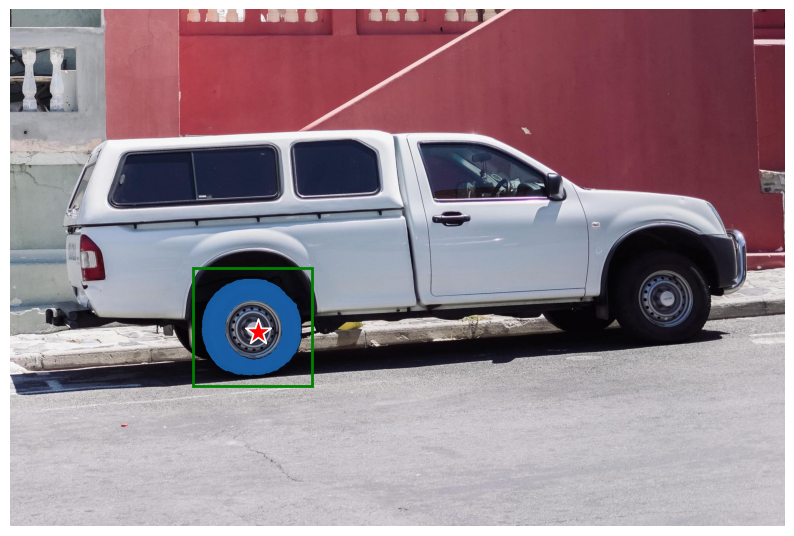

In [66]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## 批量提示输入

SamPredictor 可以使用 `predict_torch` 方法对同一张图像进行多次输入提示。 该方法假设输入的点已经是torch张量并且已经转换为输入帧。 例如，假设我们有几个来自对象检测器的框输出。

In [67]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

将框转换为输入帧，然后预测掩码。 `SamPredictor` 将必要的转换存储为 `transform` 字段以便于访问，尽管它也可以直接实例化以用于例如 一个数据加载器（参见 `segment_anything.utils.transforms`）。

In [68]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [69]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

oneflow.Size([4, 1, 1200, 1800])

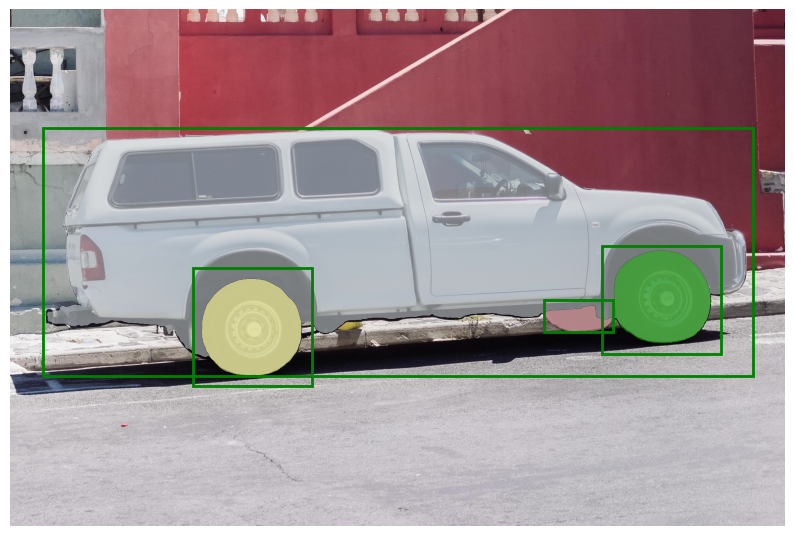

In [70]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## 端到端批量推理

如果所有提示都提前可用，则可以以端到端的方式直接运行 SAM。 这也允许对图像进行批处理。

In [71]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

图像和提示都作为已转换为正确帧的 PyTorch 张量输入。 输入被打包为图像列表，其中每个元素都是一个包含以下键的字典：
* `image`: 输入图像作为 CHW 格式的 PyTorch 张量。
* `original_size`: 转换为 SAM 输入之前的图像大小，格式为 (H, W)。
* `point_coords`: 点提示的批量坐标。
* `point_labels`: 点提示的批量标签。
* `boxes`: 批量输入框。
* `mask_inputs`: 批量输入掩码。

If a prompt is not present, the key can be excluded.

In [72]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [73]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

运行模型。

In [74]:
batched_output = sam(batched_input, multimask_output=False)

输出是每个输入图像的结果列表，其中列表元素是具有以下键的字典：
* `masks`: 预测二进制掩码的批量torch张量，原始图像的大小。
* `iou_predictions`: 模型对每个掩码质量的预测。
* `low_res_logits`: 每个掩码未归一化的概率，可以在之后的迭代中作为掩码输入传回模型。

In [75]:
batched_output[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

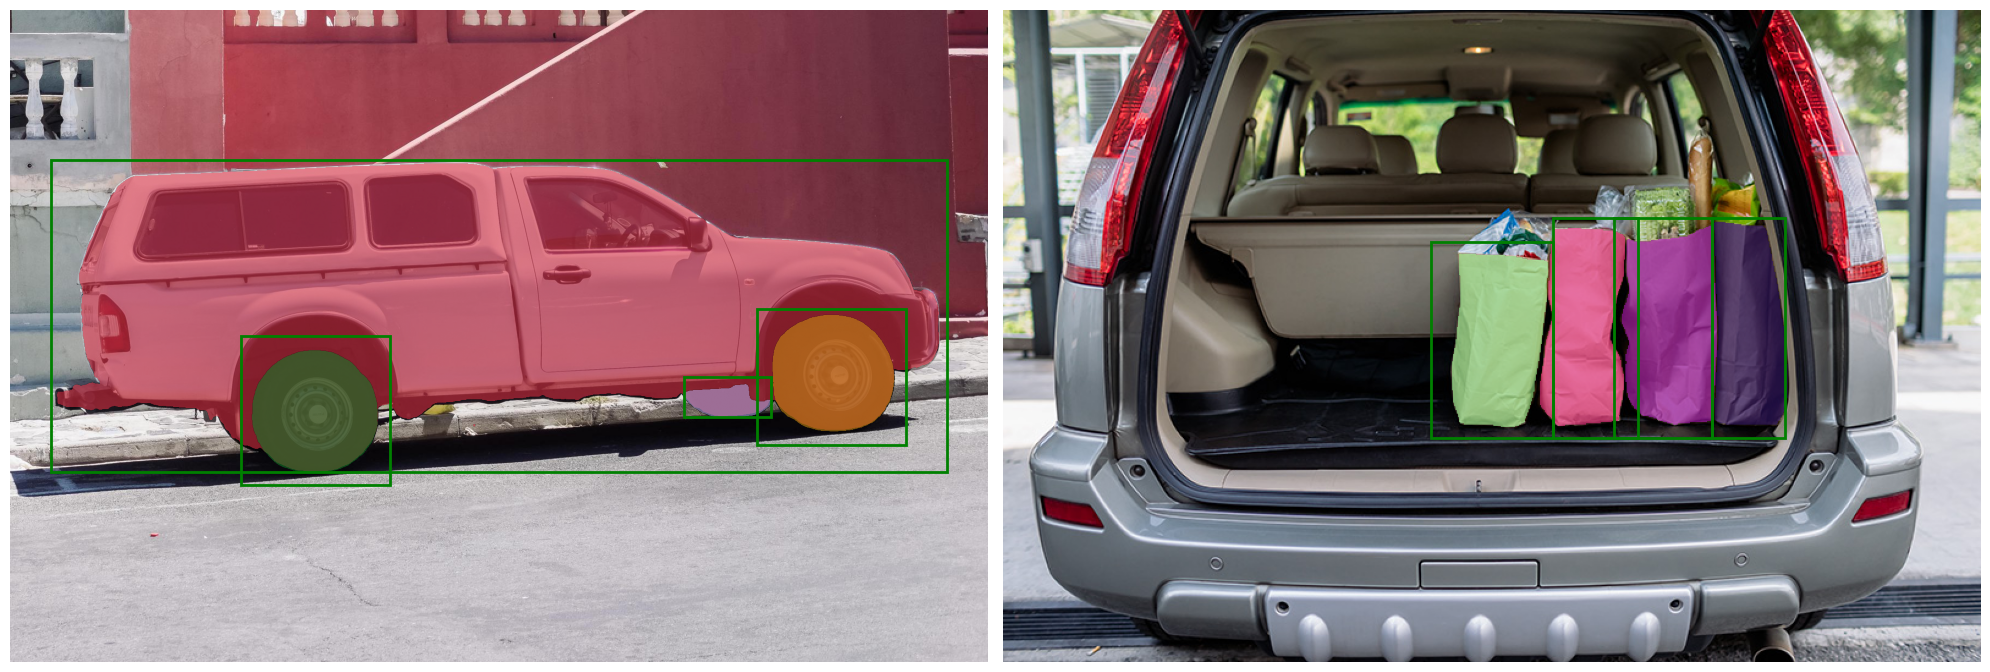

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()